In [1]:
!pip install xgboost
!pip install shap

Using basic libraries for calculation, data and modeling.

In [2]:
import numpy as np
import pandas as pd

Check current folder, get updated files if available.

In [3]:
!pwd
#!wget -N https://gitlab.com/dzwietering/corona/-/raw/master/zzprogress.csv
!wget -N https://www.acaps.org/sites/acaps/files/resources/files/acaps_covid19_government_measures_dataset_0.xlsx

/home/zwieteri/git/corona/pydata
--2021-03-04 14:13:04--  https://www.acaps.org/sites/acaps/files/resources/files/acaps_covid19_government_measures_dataset_0.xlsx
Resolving www.acaps.org (www.acaps.org)... 151.80.35.46
Connecting to www.acaps.org (www.acaps.org)|151.80.35.46|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘acaps_covid19_government_measures_dataset_0.xlsx’ not modified on server. Omitting download.



Read the generated country progress file, read the proper columns as dates.

In [4]:
df_prog = pd.read_csv(
    'zzprogress.csv',
    parse_dates=[8, 9, 10])
df_prog.tail(5)[::-1].transpose()

180                  179                  178  \
iso2                       ZM                   ZA                   XK   
cname                  Zambia         South_Africa               Kosovo   
iso3                      ZMB                  ZAF                  XKX   
ccont                  Africa               Africa               Europe   
popdata            17861034.0           58558267.0            1798506.0   
rsquared             0.995188             0.978311             0.994462   
progress             1.085406             0.035563              0.93418   
final              935.923468        776113.913893          1120.462905   
start     2020-05-11 00:00:00  2020-04-05 00:00:00  2020-03-21 00:00:00   
peak      2020-05-17 00:00:00  2020-09-11 00:00:00  2020-04-18 00:00:00   
floor     2020-05-30 00:00:00  2021-11-02 00:00:00  2020-06-18 00:00:00   
beta                 5.663459            81.831457            16.975078   
mu                 138.281355           254.968956           108.853127   
maxcur             680.472542         48963.953211             330.4606   

                                   177                     176  
iso2                                VI                      VG  
cname     United_States_Virgin_Islands  British_Virgin_Islands  
iso3                               VIR                     VGB  
ccont                          America                 America  
popdata                       104579.0                 30033.0  
rsquared                      0.966921                0.960652  
progress                      0.783359                0.730127  
final                        48.873759                 8.21775  
start              2020-03-17 00:00:00     2020-03-28 00:00:00  
peak               2020-04-17 00:00:00     2020-04-27 00:00:00  
floor              2020-06-19 00:00:00     2020-06-20 00:00:00  
beta                         20.170511               22.522308  
mu                          107.945431              117.520926  
maxcur                       12.230366                1.848767

Have a look at the countries with the highest estimated part of the population concurrently infected. Therefore, we divide the maximum current from the estimate by the population data. We use a log scale due to large differences and show countries with values above 1 per thousand.

In [5]:
df_prog['mcpop'] = df_prog['maxcur'] / df_prog['popdata']
df_prog[df_prog['mcpop'] > 1/1000].sort_values(by=['mcpop']).plot(
    x='iso2',
    y='mcpop',
    kind='barh',
    logx=True,
    figsize=(16, 9),
    grid=True)

The log of infected seems a good initial measure, so we define it as target.

In [6]:
df_prog['target'] = np.log10(df_prog['mcpop'])
df_prog['target'].describe()

count    181.000000
mean      -3.714819
std        0.687463
min       -5.030719
25%       -4.260580
50%       -3.786451
75%       -3.135566
max       -2.082021
Name: target, dtype: float64

For looking at country behavior we try the ACAPS government measures dataset.

In [7]:
df_meas = pd.read_excel(
    'acaps_covid19_government_measures_dataset_0.xlsx',
    sheet_name='Dataset')
df_meas.tail(5)[::-1].transpose()

23922  \
ID                                                             138074   
ISO                                                               ZWE   
COUNTRY                                                      Zimbabwe   
REGION                                                         Africa   
ADMIN_LEVEL_NAME                                                  NaN   
PCODE                                                             NaN   
LOG_TYPE                         Introduction / extension of measures   
CATEGORY                                       Public health measures   
MEASURE             Health screenings in airports and border cross...   
TARGETED_POP_GROUP                                            checked   
COMMENTS            Passengers will undergo temperature checks at ...   
NON_COMPLIANCE                                          Not Available   
DATE_IMPLEMENTED                                  2020-10-01 00:00:00   
SOURCE                                                      Emirates    
SOURCE_TYPE                                                     Media   
LINK                https://www.emirates.com/za/english/help/faqs/...   
ENTRY_DATE                                        2020-10-30 00:00:00   
Alternative source                                                NaN   

                                                                23921  \
ID                                                              13723   
ISO                                                               ZWE   
COUNTRY                                                      Zimbabwe   
REGION                                                         Africa   
ADMIN_LEVEL_NAME                                                  NaN   
PCODE                                                             NaN   
LOG_TYPE                                            Phase-out measure   
CATEGORY                                            Social distancing   
MEASURE                                               Schools closure   
TARGETED_POP_GROUP                                                NaN   
COMMENTS            the re-opening of schools be moved from the pr...   
NON_COMPLIANCE                                         Not applicable   
DATE_IMPLEMENTED                                  2020-07-28 00:00:00   
SOURCE                                        Ministry of Information   
SOURCE_TYPE                                              Social media   
LINK                https://twitter.com/MinOfInfoZW/status/1270378...   
ENTRY_DATE                                        2020-06-13 00:00:00   
Alternative source                                                NaN   

                                                                23920  \
ID                                                              14734   
ISO                                                               ZWE   
COUNTRY                                                      Zimbabwe   
REGION                                                         Africa   
ADMIN_LEVEL_NAME                                                  NaN   
PCODE                                                             NaN   
LOG_TYPE                                            Phase-out measure   
CATEGORY                                            Social distancing   
MEASURE                     Closure of businesses and public services   
TARGETED_POP_GROUP                                            checked   
COMMENTS            Restaurants now allowed to serve sit-in meals ...   
NON_COMPLIANCE                                         Not applicable   
DATE_IMPLEMENTED                                  2020-06-30 00:00:00   
SOURCE                                        Ministry of Information   
SOURCE_TYPE                                              Social media   
LINK                https://twitter.com/MinOfInfoZW/status/1278043...   
ENTRY_DATE                                     

The dataset contains both start and end of measures, so let's see how they are coded.

In [8]:
print(df_meas['LOG_TYPE'].unique())

['Introduction / extension of measures' 'Phase-out measure']


For now, we only look at introductions before the cutoff date.

In [9]:
df_meas = df_meas[(df_meas['LOG_TYPE'] == 'Introduction / extension of measures') &
                  (df_meas['DATE_IMPLEMENTED'] < '20200601')]
df_meas.tail(5)[::-1].transpose()

23913  \
ID                                                              11771   
ISO                                                               ZWE   
COUNTRY                                                      Zimbabwe   
REGION                                                         Africa   
ADMIN_LEVEL_NAME                                                  NaN   
PCODE                                                             NaN   
LOG_TYPE                         Introduction / extension of measures   
CATEGORY                                                     Lockdown   
MEASURE                                              Partial lockdown   
TARGETED_POP_GROUP                                                NaN   
COMMENTS            Partial lockdown (level 2) extended indefinite...   
NON_COMPLIANCE                                         Not available    
DATE_IMPLEMENTED                                  2020-05-17 00:00:00   
SOURCE                                            Zimbabwe Government   
SOURCE_TYPE                                                Government   
LINK                http://www.zim.gov.zw/index.php/en/news-room/l...   
ENTRY_DATE                                        2020-05-25 00:00:00   
Alternative source   https://zw.usembassy.gov/covid-19-information-2/   

                                                                23910  \
ID                                                              11773   
ISO                                                               ZWE   
COUNTRY                                                      Zimbabwe   
REGION                                                         Africa   
ADMIN_LEVEL_NAME                                                  NaN   
PCODE                                                             NaN   
LOG_TYPE                         Introduction / extension of measures   
CATEGORY                                                     Lockdown   
MEASURE                                              Partial lockdown   
TARGETED_POP_GROUP                                                NaN   
COMMENTS                     Zimbabwe extends lockdown until May 15th   
NON_COMPLIANCE                                         Not available    
DATE_IMPLEMENTED                                  2020-05-04 00:00:00   
SOURCE                                                          Garda   
SOURCE_TYPE                                                     Media   
LINK                https://www.garda.com/crisis24/news-alerts/339...   
ENTRY_DATE                                        2020-05-25 00:00:00   
Alternative source                                                NaN   

                                                                23909  \
ID                                                              11772   
ISO                                                               ZWE   
COUNTRY                                                      Zimbabwe   
REGION                                                         Africa   
ADMIN_LEVEL_NAME                                                  NaN   
PCODE                                                             NaN   
LOG_TYPE                         Introduction / extension of measures   
CATEGORY                                       Public health measures   
MEASURE                 Requirement to wear protective gear in public   
TARGETED_POP_GROUP                                                NaN   
COMMENTS            The government of Zimbabwe has officially made...   
NON_COMPLIANCE                                       Arrest/Detention   
DATE_IMPLEMENTED                                  2020-05-04 00:00:00   
SOURCE                                                    Africa News   
SOURCE_TYPE                                                     Media   
LINK                https://www.africanews.com/2020/05/10/zimbabwe...   
ENTRY_DATE                                     

Both datasets contain the three character ISO country code, so we join on those columns.

In [10]:
df_full = pd.merge(
    df_prog,
    df_meas,
    left_on='iso3',
    right_on='ISO')
df_full.dtypes

iso2                          object
cname                         object
iso3                          object
ccont                         object
popdata                      float64
rsquared                     float64
progress                     float64
final                        float64
start                 datetime64[ns]
peak                  datetime64[ns]
floor                 datetime64[ns]
beta                         float64
mu                           float64
maxcur                       float64
mcpop                        float64
target                       float64
ID                             int64
ISO                           object
COUNTRY                       object
REGION                        object
ADMIN_LEVEL_NAME              object
PCODE                        float64
LOG_TYPE                      object
CATEGORY                      object
MEASURE                       object
TARGETED_POP_GROUP            object
COMMENTS                      object
N

The first analysis could be how early measures were implemented, so we calculate the difference between the implemented date and our estimated start date in days.

In [11]:
df_full['days'] = (df_full['DATE_IMPLEMENTED'] - df_full['start']).dt.days
df_full['days'].describe()

count    8939.000000
mean       12.201812
std        33.514240
min      -132.000000
25%        -7.000000
50%        11.000000
75%        36.000000
max       118.000000
Name: days, dtype: float64

To reduce this to a source dataset for modeling, we pivot to columns with the average number of days for categories, indexed by country code.

In [12]:
df_aggr = df_full.pivot_table(
    index='iso2',
    columns='CATEGORY',
    values='days',
    aggfunc='mean')
df_aggr.tail(10)[::-1].transpose()

iso2                                           ZM         ZA         VE  \
CATEGORY                                                                  
Governance and socio-economic measures -37.000000  11.800000 -36.111111   
Humanitarian exemption                        NaN        NaN        NaN   
Lockdown                                      NaN  -2.500000 -49.000000   
Movement restrictions                  -32.166667  -6.000000 -44.555556   
Public health measures                 -50.100000  12.133333 -37.500000   
Social distancing                      -49.833333   2.800000 -65.400000   

iso2                                          VC    UZ         UY         US  \
CATEGORY                                                                       
Governance and socio-economic measures       NaN   NaN  25.846154  20.592105   
Humanitarian exemption                       NaN   NaN        NaN        NaN   
Lockdown                                     NaN   NaN  13.000000        NaN   
Movement restrictions                        NaN -14.0  31.300000  13.769231   
Public health measures                 -1.894737  52.0  39.583333  19.256410   
Social distancing                      -6.000000   NaN  39.500000   3.333333   

iso2                                           UK         UA         TT  
CATEGORY                                                                 
Governance and socio-economic measures  40.759259  -1.375000  -3.400000  
Humanitarian exemption                        NaN        NaN        NaN  
Lockdown                                24.500000  10.500000  14.750000  
Movement restrictions                   46.250000 -16.333333   3.571429  
Public health measures                  34.815789   7.730769   6.500000  
Social distancing                       12.838710  -4.571429  22.333333

The final dataset contains this data combined with our estimates.

In [13]:
df_final = pd.merge(
    df_prog,
    df_aggr,
    left_on='iso2',
    right_index=True)
df_final.reset_index(
    drop=True,
    inplace=True)
df_final.tail(5)[::-1].transpose()

149  \
iso2                                                     ZM   
cname                                                Zambia   
iso3                                                    ZMB   
ccont                                                Africa   
popdata                                          17861034.0   
rsquared                                           0.995188   
progress                                           1.085406   
final                                            935.923468   
start                                   2020-05-11 00:00:00   
peak                                    2020-05-17 00:00:00   
floor                                   2020-05-30 00:00:00   
beta                                               5.663459   
mu                                               138.281355   
maxcur                                           680.472542   
mcpop                                              0.000038   
target                                            -4.419096   
Governance and socio-economic measures                -37.0   
Humanitarian exemption                                  NaN   
Lockdown                                                NaN   
Movement restrictions                            -32.166667   
Public health measures                                -50.1   
Social distancing                                -49.833333   

                                                        148  \
iso2                                                     ZA   
cname                                          South_Africa   
iso3                                                    ZAF   
ccont                                                Africa   
popdata                                          58558267.0   
rsquared                                           0.978311   
progress                                           0.035563   
final                                         776113.913893   
start                                   2020-04-05 00:00:00   
peak                                    2020-09-11 00:00:00   
floor                                   2021-11-02 00:00:00   
beta                                              81.831457   
mu                                               254.968956   
maxcur                                         48963.953211   
mcpop                                              0.000836   
target                                            -3.077712   
Governance and socio-economic measures                 11.8   
Humanitarian exemption                                  NaN   
Lockdown                                               -2.5   
Movement restrictions                                  -6.0   
Public health measures                            12.133333   
Social distancing                                       2.8   

                                                        147  \
iso2                                                     VE   
cname                                             Venezuela   
iso3                                                    VEN   
ccont                                               America   
popdata                                          28515829.0   
rsquared                                           0.997226   
progress                                           1.200132   
final                                           1088.094324   
start                                   2020-05-20 00:00:00   
peak                                    2020-05-25 00:00:00   
floor                                   2020-06-04 00:00:00   
beta                                               5.080584   
mu                                               146.432436   
maxcur                                           841.073032   
mcpop                                              0.000029   
target                                            -4.530252   
Governance and socio-economic measures           -36.111111   
Humanitarian exemption

Just an example check on data, in this case the relation between lockdown and the target column.

In [14]:
df_final.plot(
    kind="scatter",
    x="Lockdown",
    y="target",
    alpha=1/2)

If we start using this model for predictions, we need to split the dataset. For now we are still exploring so we use all the data for analysis. The feature columns are all the columns added to the right of our dataset with estimations. The correlation matrix for our training columns shows the relation between measures.

In [15]:
featcols = len(df_prog.columns)
features = df_final.columns[featcols:]

#from sklearn.model_selection import train_test_split
#x_trn, x_tst, y_trn, y_tst = train_test_split(df_final[features], df_final['mcpop'])

x_trn = df_final[features]
y_trn = df_final['target']

(x_trn
  .corr()
  .style.background_gradient(cmap='Purples')
  .set_precision(2))

Create the XGBoost data structure for training and check parameters to prevent overfitting on this small dataset. Then check the error rate between the test and train data used internally by XGBoost. If the test error rate is much higher, we are overfitting.

[0]	train-rmse:3.86978+0.02129	test-rmse:3.86426+0.21044
[10]	train-rmse:1.46910+0.00990	test-rmse:1.46112+0.19466
[20]	train-rmse:0.70171+0.00680	test-rmse:0.71057+0.15541
[30]	train-rmse:0.52018+0.00891	test-rmse:0.54740+0.12360
[40]	train-rmse:0.48654+0.00725	test-rmse:0.52145+0.12068
[50]	train-rmse:0.47545+0.00836	test-rmse:0.51666+0.12269
[60]	train-rmse:0.47413+0.00924	test-rmse:0.51732+0.12181
[70]	train-rmse:0.47061+0.00971	test-rmse:0.51809+0.12221
[80]	train-rmse:0.46772+0.00821	test-rmse:0.51602+0.12100
[90]	train-rmse:0.46550+0.00819	test-rmse:0.51562+0.12040
[99]	train-rmse:0.46242+0.00761	test-rmse:0.51534+0.12224


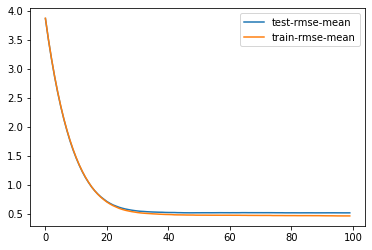

In [16]:
import xgboost as xgb

dtrn = xgb.DMatrix(
    x_trn,
    label=y_trn)
#dtst = xgb.DMatrix(x_tst)

params = {
    #'objective':'reg:squarederror',
    'eta':1/10,
    'gamma':2,
    #'min_child_weight':10,
    #'tree_method':'hist',
    #'seed':0,
    #'max_depth':3,
    'colsample_bytree':0.7,
    'subsample':0.7,
    'nthread':1
}

hist = xgb.cv(
    params,
    dtrn,
    nfold=10,
    as_pandas=True,
    num_boost_round=100,
    verbose_eval=10,
    early_stopping_rounds=1000,
    show_stdv=True,
    seed=0)
hist.plot(y=["test-rmse-mean", "train-rmse-mean"])

Train the model using the parameters found above and show the feature importance. Note that this can be both a positive and negative influence.

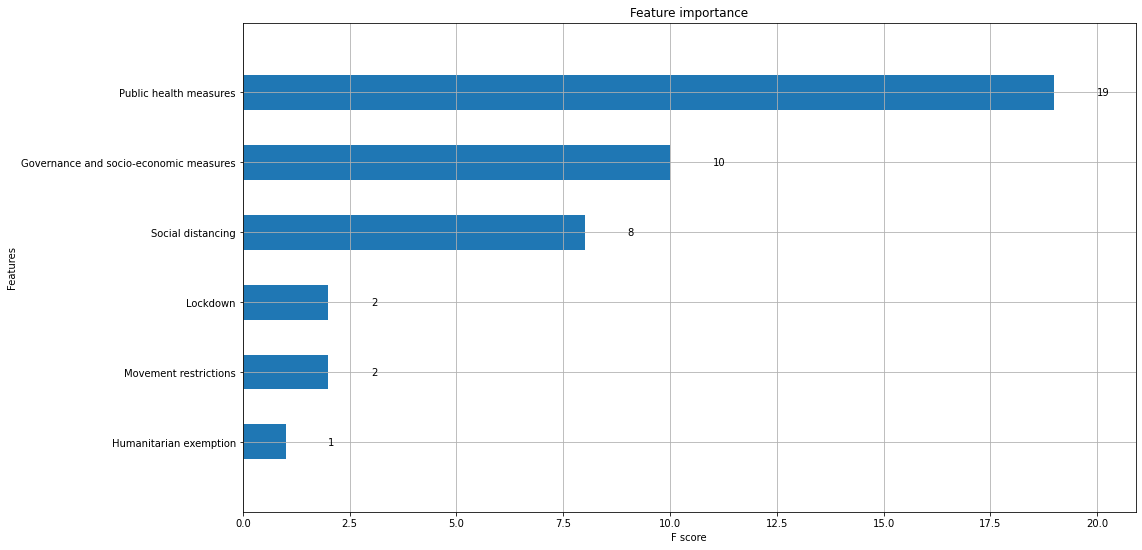

In [17]:
bst = xgb.train(
    params,
    dtrn,
    num_boost_round=100,
    verbose_eval=1)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(16, 9))

xgb.plot_importance(bst, ax=ax, height=1/2)

The actual XGBoost model is an ensemble of decision trees that can be hard to interpret. SHAP is an analysis library that shows the influence of factors based on this model. First we choose a country and see how the estimate relates to measures.

In [18]:
country = 'NL'

rownum = df_final[df_final['iso2'] == country].index[0]

import shap

shap.initjs()

explainer = shap.TreeExplainer(bst, x_trn)
shap_values = explainer.shap_values(x_trn)

shap.force_plot(
    explainer.expected_value,
    shap_values[rownum],
    x_trn.loc[rownum])

When we take all these plots, rotate and stack them we get a global view of the model.

In [19]:
shap.force_plot(
    explainer.expected_value,
    shap_values,
    x_trn)

Looking at individual measures we can visualize their impact on model output.

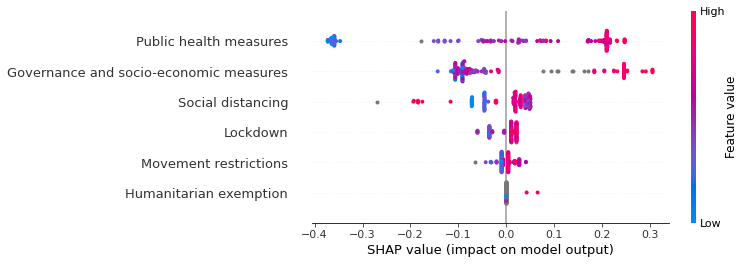

In [20]:
shap.summary_plot(
    shap_values,
    x_trn)

Finally, a similar plot to the importance plot above shows the explanatory value of measures.

In [21]:
shap.summary_plot(
    shap_values,
    x_trn,
    plot_type="bar")

Keep exploring! Stay home, wash your hands, keep your distance.